Continuar a partir de 7:40 (aula 10)

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import warnings

from statsmodels.tsa.ar_model import AutoReg as AR

from matplotlib import pyplot as plt

<Axes: ylabel='serie_final'>

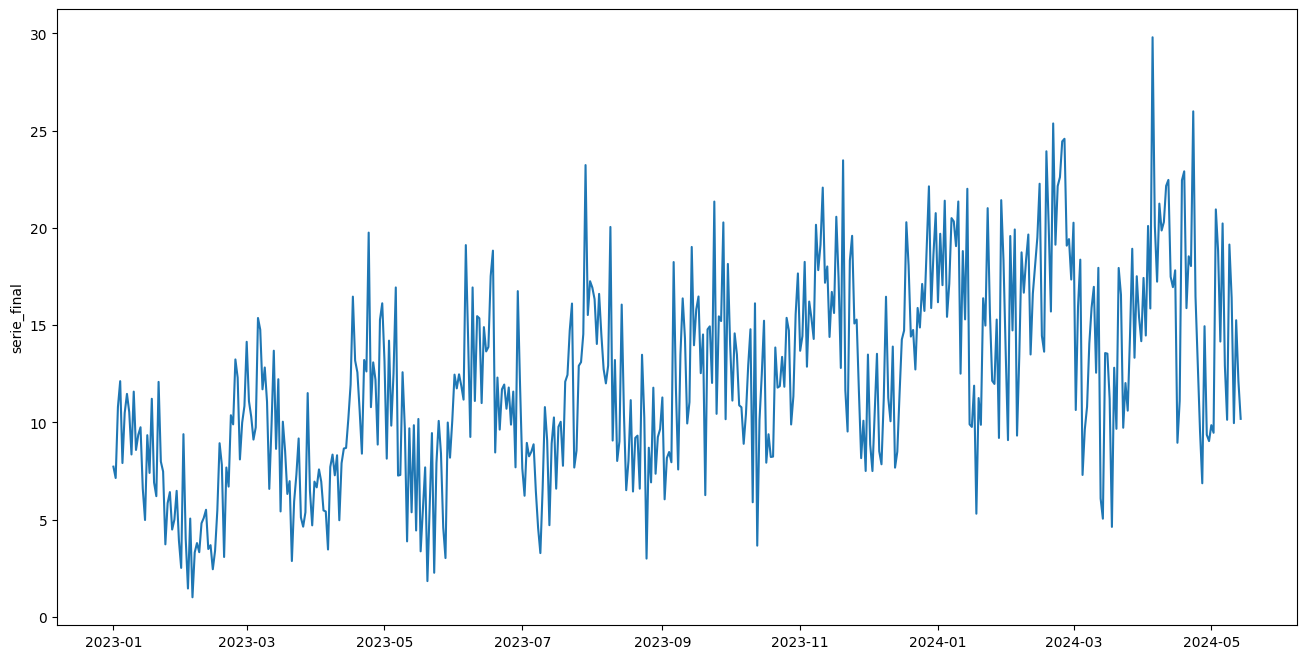

In [2]:
# configuracao da series
np.random.seed(42)
n = 500

# criacao da series perfeita
trend = np.linspace( 0, 0, n)
noise = np.random.normal( 0, 1, n) 
serie_perfeita = trend + noise
dates = pd.date_range( start='2023-01-01', periods=n, freq='D' )
serie_perfeita = pd.Series( serie_perfeita, index=dates, name='serie_perfeita')

# Quebra Premissa 1: Linearidade 
trend_break = np.linspace( 0, 10, n )
serie_nao_linear = serie_perfeita + trend_break

# Quebra Premissa 2: Estacionariedade 
seasonality = 3 * np.sin( 2 * np.pi * np.arange( n ) / 50 )
serie_nao_estacionaria = serie_perfeita + seasonality

# Quebra Premissa 3: Autocorrelacao dos residucos 
autoregressive = np.zeros( n)
autoregressive[0] = noise[0]
for t in range( 1, n ):
 autoregressive[t] = 0.8 * autoregressive[t-1] + np.random.normal( 0, 0.5)
serie_nao_autocorrelacao = serie_perfeita + autoregressive

# Quebra Premissa 4: Homoscedasticidade 
non_normal = noise * np.linspace( 1, 3, n )
serie_nao_homoscedastica = serie_perfeita + non_normal

# Quebra Premissa 5: Não nomralidade dos residuos 
non_normal_noise = np.random.exponential( scale=1, size= n )
serie_nao_normal = trend + non_normal_noise

# Combinar as series
serie_final = (
 serie_perfeita
 + trend_break
 + seasonality
 + autoregressive
 + non_normal
 + non_normal_noise
)
serie_final = pd.Series( serie_final, index=dates, name='serie_final' )
serie_final = serie_final - serie_final.min() + 1

# Visualizacao das series
plt.figure( figsize=( 16, 8 ) )
sns.lineplot( serie_final )

Separação dos dados em treinament, validação e teste

In [3]:
# Divisão da Série em Conjuntos de Treinamento, Validação e Teste
train_size = int( 0.8 * len( serie_final ) )
validation_size = int( 0.1 * len( serie_final ) )

# Train-Val-Test Split
train = serie_final[:train_size]
validation = serie_final[train_size:train_size + validation_size]
test = serie_final[train_size + validation_size:]

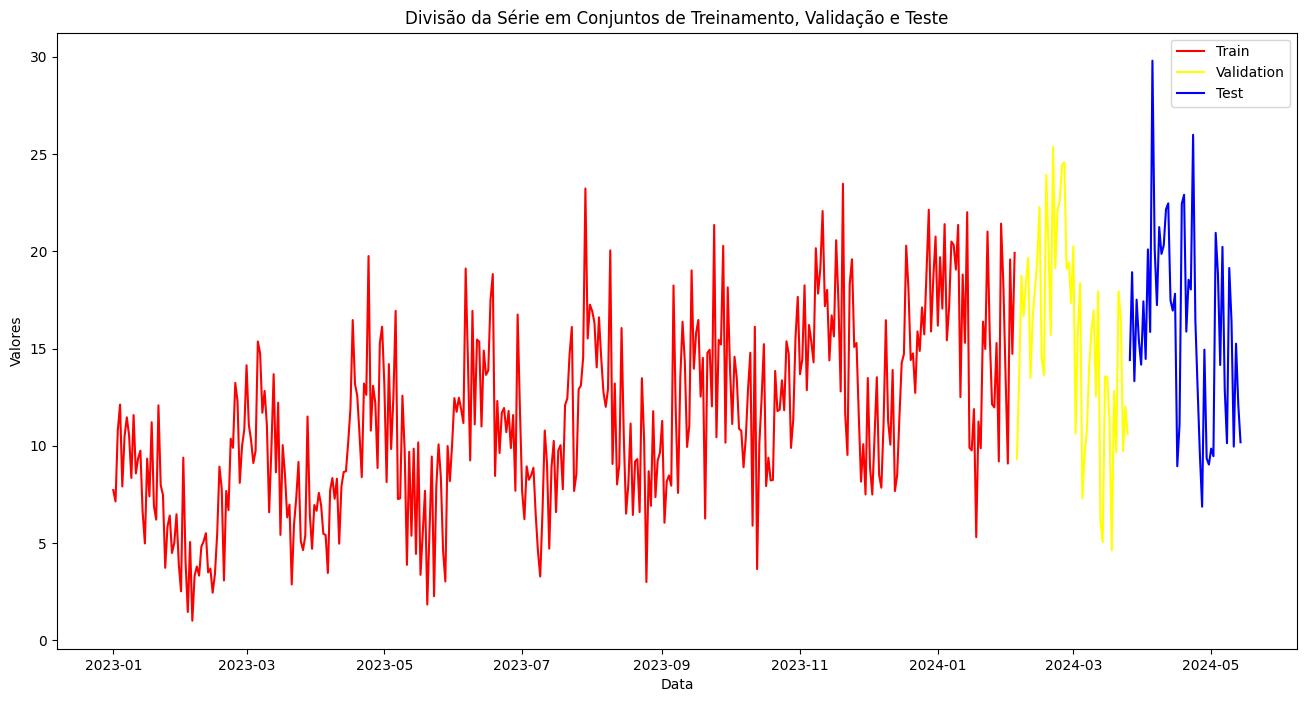

In [4]:
plt.figure( figsize=( 16, 8 ) )
sns.lineplot( train, label='Train', color='red' )
sns.lineplot( validation, label='Validation', color='yellow' )
sns.lineplot( test, label='Test', color='blue' )
plt.title( 'Divisão da Série em Conjuntos de Treinamento, Validação e Teste' )
plt.xlabel( 'Data' )
plt.ylabel( 'Valores' )
plt.legend()

Rolling Forecast Origin

In [5]:
# # Definindo o modelo
# model = AR(train, lags=1)

# # Treinamento do modelo
# model_fit = model.fit()

# # Previsão para o conjunto de validação
# #predictions = model_fit.predict(start=len(train), end=len(train) + len(validation) - 1, dynamic=False)
# predictions = model_fit.forecast(steps = 1).iloc[0]

In [6]:
warnings.filterwarnings("ignore")
train_series = train.copy()

predictions = []
actuals = []
for t in range(len(validation)):
    # # Adicionando o valor real ao conjunto de treinamento
    # train_series = train_series.append(validation.iloc[t])
    
    # Definindo o modelo
    model = AR(train_series, lags=1)
    
    # Treinamento do modelo
    model_fit = model.fit()
    
    # Previsão para o próximo passo
    prediction = model_fit.forecast(steps=1).iloc[0]
        # Armazenando a previsão e o valor real
    predictions.append(prediction)
    actuals.append(validation.iloc[t])

    train_series = pd.concat([train_series, pd.Series(validation.iloc[0], index=[validation.index[0]])])

# DataFrame para armazenar previsões e valores reais
df = pd.DataFrame({
    'Previsão': predictions,
    'Real': actuals
}, index=validation.index)

In [7]:
df.head()

,Previsão,Real
2024-02-05,16.419829,9.315635
2024-02-06,10.117938,13.403523
2024-02-07,10.115590,18.740215
2024-02-08,10.113255,16.666690
2024-02-09,10.110934,18.352215


Aula 16

In [8]:
# Calculo do desempenho
# from sklearn.metrics import mean_squared_error, mean_absolute_error
errors = df['Real'] - df['Previsão']

rmse = np.sqrt((errors**2).mean())
mae = (np.abs(errors)).mean()
mape = np.mean(np.abs(errors / df['Real']))

In [9]:
mape

np.float64(0.3996407658364868)

In [10]:
mae

np.float64(6.456649144584193)

In [11]:
rmse

np.float64(7.618921765633569)

Continuar aula 16 - a partir de 7:19

In [12]:
# Metricas de qualidade do ajuste
# AIC e BIC
log_likelihood = model_fit.llf
num_params = model_fit.params.shape[0]
num_obs = len(train_series)
aic = -2 * log_likelihood + 2 * num_params
bic = -2 * log_likelihood + num_params * np.log(num_obs)

In [13]:
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f"AIC: {aic}")
print(f"BIC: {bic}")

RMSE: 7.618921765633569
MAE: 6.456649144584193
MAPE: 0.3996407658364868
AIC: 2409.54780461141
BIC: 2417.7662997769385


Há várias formas de buscar os melhores valores de hiperparâmetros

Testar as outras opções da aula: Grid Search, Random Search, Bayesian Optimization, AutoML

## Fine Tuning

In [14]:
# Fine-tuning do ARIMA
lags_values = [1, 2, 3, 4, 5]
num_interations = 5
results_val = pd.DataFrame()

In [15]:
for _ in range (num_interations):
    # Escolha de um valor aleatório para o lag
    lag = np.random.choice(lags_values)
    print(f"Testando parâmetro: {lag}")

    # Start Rolling Forecast Origin
    predictions = []
    actuals = []
    train_series = train.copy()
    for t in range(len(validation)):
        # Adicionando o valor real ao conjunto de treinamento
        # train_series = train_series.append(validation.iloc[t])
        
        # Definindo o modelo
        model = AR(train_series, lags=lag)
        
        # Treinamento do modelo
        model_fit = model.fit()
        
        # Previsão para o próximo passo
        forecast = model_fit.forecast(steps=1).iloc[0]
        # Armazenando a previsão e o valor real
        predictions.append(forecast)
        actuals.append(validation.iloc[t])

        # Adicionando o valor real ao conjunto de treinamento
        train_series = pd.concat([train_series, pd.Series(validation.iloc[t], index=[validation.index[t]])])

    # DataFrame para armazenar previsões e valores reais
    df_val = pd.DataFrame({
        'Previsão': predictions,
        'Real': actuals
    }, index=validation.index)

    # Computando o desempenho
    errors = df['Real'] - df['Previsão']
    rmse_val = np.sqrt((errors**2).mean())
    mae_val = (np.abs(errors)).mean()
    mape_val = np.mean(np.abs(errors / df['Real']))

    # Calculando AIC e BIC
    log_likelihood = model_fit.llf
    num_params = model_fit.params.shape[0]
    num_obs = len(train_series)

    aic_val = -2 * log_likelihood + 2 * num_params
    bic_val = -2 * log_likelihood + num_params * np.log(num_obs)

    performance = pd.DataFrame({'Lag': lag,
                                'RMSE_VAL': rmse_val, 
                                'MAE_VAL': mae_val, 
                                'MAPE_VAL': mape_val, 
                                'AIC_VAL': aic_val, 
                                'BIC_VAL': bic_val}, index=[0]
                                )
    results_val = pd.concat([results_val, performance], ignore_index=True)

# Exibindo os resultados
results_val.sort_values(by='RMSE_VAL', ascending=True).head(10)

Testando parâmetro: 3
Testando parâmetro: 1
Testando parâmetro: 5
Testando parâmetro: 3
Testando parâmetro: 3


,Lag,RMSE_VAL,MAE_VAL,MAPE_VAL,AIC_VAL,BIC_VAL
0,3,7.618922,6.456649,0.399641,2389.491687,2405.928678
1,1,7.618922,6.456649,0.399641,2488.704187,2496.922683
2,5,7.618922,6.456649,0.399641,2366.905568,2391.561053
3,3,7.618922,6.456649,0.399641,2389.491687,2405.928678
4,3,7.618922,6.456649,0.399641,2389.491687,2405.928678


Continuar a partir da aula 18

### Previsões para o conjunto de teste

In [16]:
# Best parameter for fine-tuning
lag = 5

# Start Rolling Forecast Origin
predictions = []
actuals = []
results_test = pd.DataFrame()
train_series = pd.concat([train, validation])

# Rolling Forecast Origin
for t in range(len(test)):
    # Adicionando o valor real ao conjunto de treinamento
    # train_series = train_series.append(validation.iloc[t])

    # Definindo o modelo
    model = AR(train_series, lags=lag)

    # Treinamento do modelo
    model_fit = model.fit()

    # Previsão para o próximo passo
    forecast = model_fit.forecast(steps=1).iloc[0]
    # Armazenando a previsão e o valor real
    predictions.append(forecast)
    actuals.append(test.iloc[t])

    #Update the training set with the actual value
    train_series = pd.concat([train_series, pd.Series(test.iloc[t], index=[test.index[t]])])
# Adicionando o valor real ao conjunto de treinamento
# train_series = train_series.append(validation.iloc[t])

# DataFrame para armazenar previsões e valores reais
df_test = pd.DataFrame({'Previsão': predictions,'Real': actuals}, index=test.index)

# Computando o desempenho
errors = df['Real'] - df['Previsão']

rmse_test = np.sqrt((errors**2).mean())
mae_test = (np.abs(errors)).mean()
mape_test = np.mean(np.abs(errors / df['Real']))

# Calculando AIC e BIC
log_likelihood = model_fit.llf
num_params = model_fit.params.shape[0]
num_obs = len(train_series)

aic_test = -2 * log_likelihood + 2 * num_params
bic_test = -2 * log_likelihood + num_params * np.log(num_obs)

results_test = pd.DataFrame({'Lag': lag,
                             'RMSE_TEST': rmse_test,
                             'MAE_TEST': mae_test,
                             'MAPE_TEST': mape_test,
                             'AIC_TEST': aic_test,
                             'BIC_TEST': bic_test}, index=[0]
)

# Exibindo os resultados
results_test

,Lag,RMSE_TEST,MAE_TEST,MAPE_TEST,AIC_TEST,BIC_TEST
0,5,7.618922,6.456649,0.399641,2671.780423,2697.068072


In [17]:
results_test

,Lag,RMSE_TEST,MAE_TEST,MAPE_TEST,AIC_TEST,BIC_TEST
0,5,7.618922,6.456649,0.399641,2671.780423,2697.068072


### Testando por desenho

<Axes: ylabel='serie_final'>

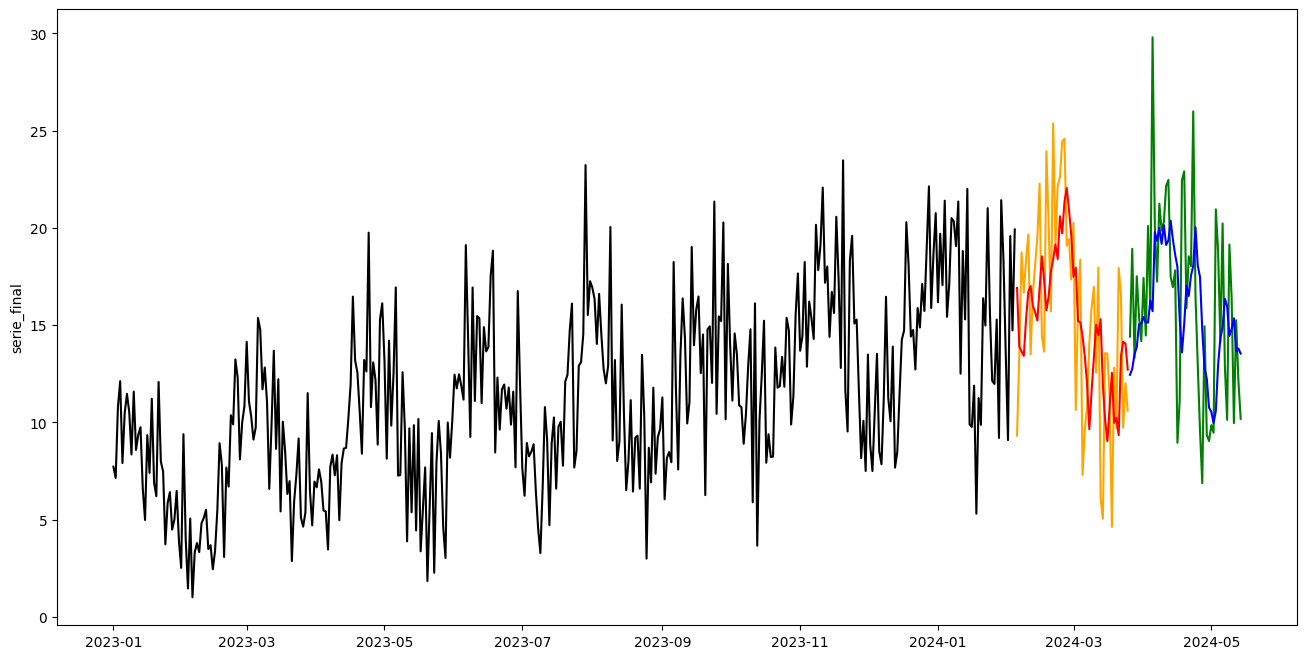

In [18]:
plt.figure( figsize=( 16, 8 ) )
sns.lineplot( train, color='black' )
sns.lineplot( validation, color='orange' )
sns.lineplot( test, color='green' )
sns.lineplot( df_val['Previsão'], color='red' )
sns.lineplot( df_test['Previsão'], color='blue' )


Há várias formas de buscar os melhores valores de hiperparâmetros

Testar as outras opções da aula: Grid Search, Random Search, Bayesian Optimization, AutoML

Continuar da aula 1 - Modelos Estatísticos (Ciclo 03)

Pesquisar sobre:

* 2.9. Modelos Hierárquicos para Séries Temporais (Hierarchical Time Series - HTS)


Continuar aula 4. Modelo AR - Gráfico PACF (10:50)

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

In [20]:
# Gerar serie temporal senoidal
np.random.seed(42)
n = 200
t = np.arange(n)
T = 20

# Criar a série senoidal com ruído
serie = np.sin(2 * np.pi * t / T)

# Criar DataFrame
dates = pd.date_range(start='2023-01-01', periods=n, freq='D')
senoidal_series = pd.Series(serie, index=dates)

<Axes: >

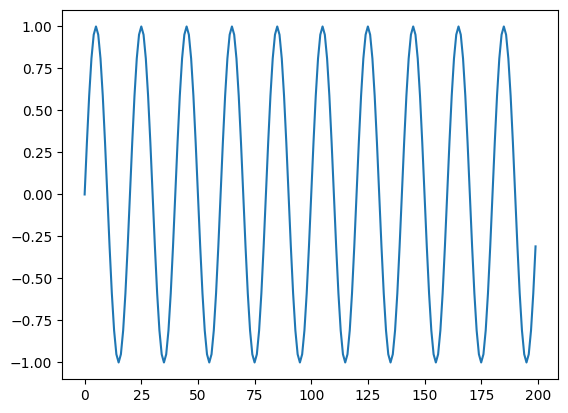

In [21]:
sns.lineplot(data=serie)

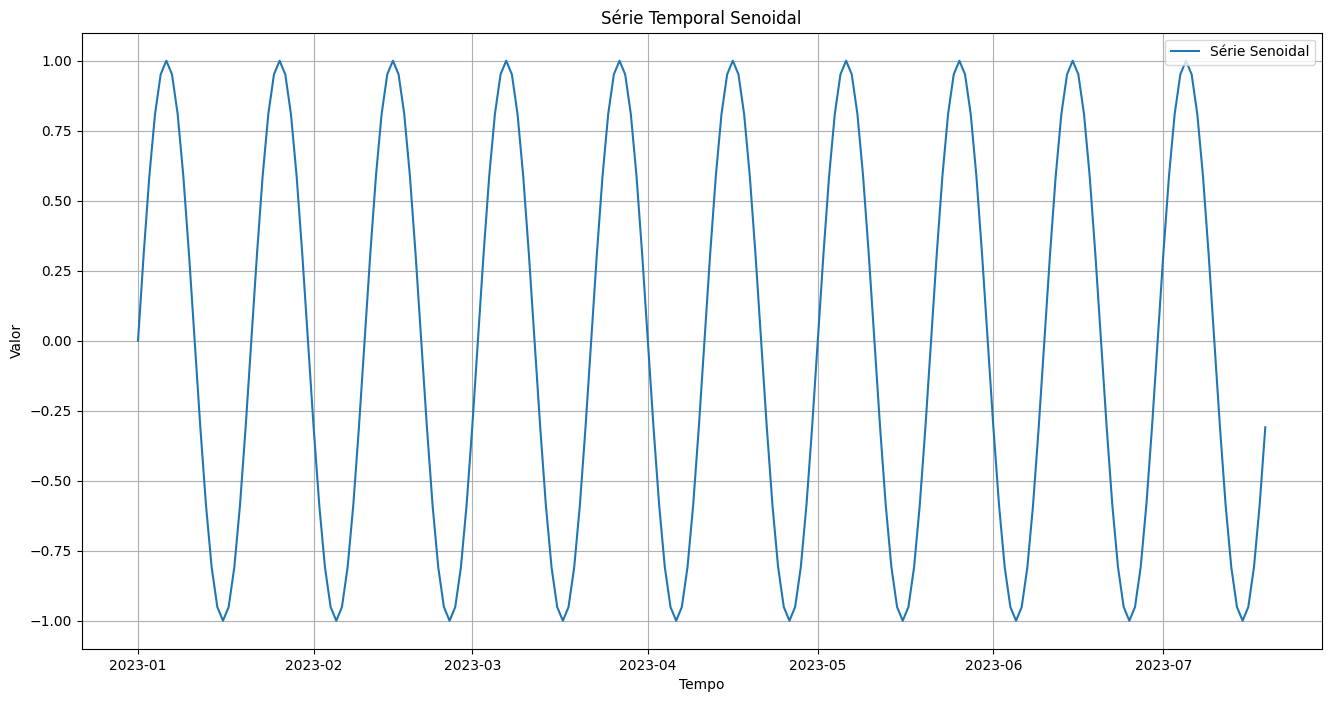

In [22]:
# Gerar serie temporal senoidal
np.random.seed(42)
n = 200
t = np.arange(n)
T = 20

# Criar a série senoidal com ruído
serie = np.sin(2 * np.pi * t / T)

# Criar DataFrame
dates = pd.date_range(start='2023-01-01', periods=n, freq='D')
senoidal_series = pd.Series(serie, index=dates)

# Plotar a série temporal
plt.figure(figsize=(16, 8))
plt.plot(senoidal_series, label='Série Senoidal')
plt.title('Série Temporal Senoidal')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()



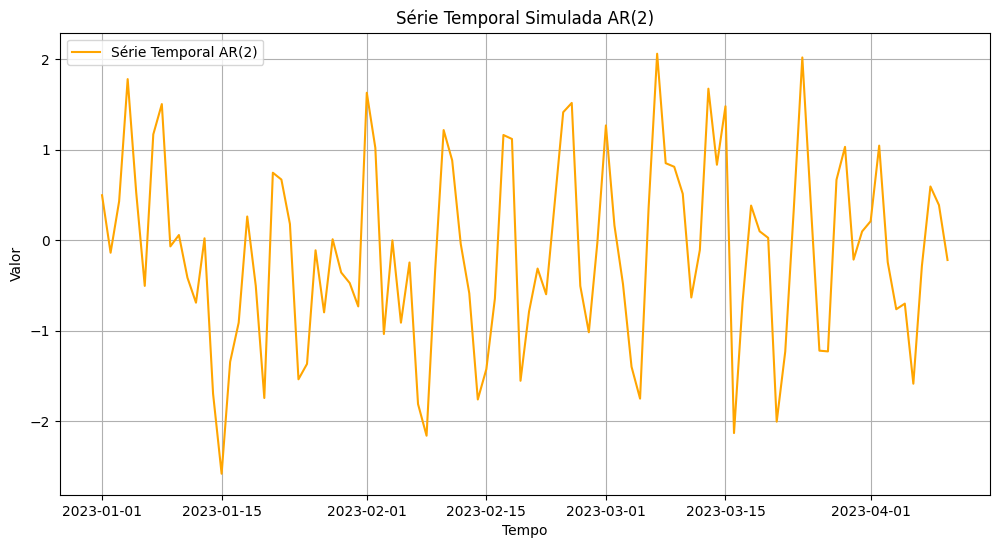

<Figure size 1200x600 with 0 Axes>

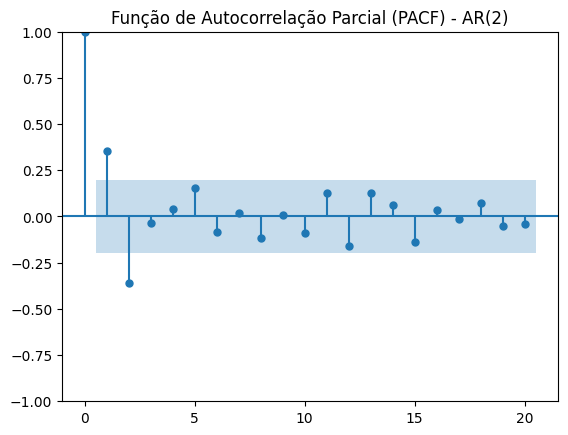

In [23]:
# Gerar uma serie temporal simulada com um processo AR (2)
np.random.seed(42)
n = 100
ar_params = [0.5, -0.3]
noise = np.random.normal(0, 1, n)

# Criar a série temporal AR(2)
series_ar = np.zeros(n)
series_ar[0], series_ar[1] = noise[0], noise[1]

for t in range(2, n):
    series_ar[t] = ar_params[0] * series_ar[t-1] + ar_params[1] * series_ar[t-2] + noise[t]

# Criar DataFrame
dates = pd.date_range(start='2023-01-01', periods=n, freq='D')
ar_series = pd.Series(series_ar, index=dates, name='AR(2) Series')

# Plotar a série temporal AR(2)
plt.figure(figsize=(12, 6))
plt.plot(ar_series, label='Série Temporal AR(2)', color='orange')
plt.title('Série Temporal Simulada AR(2)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# Plotar a função de autocorrelação parcial (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(ar_series, lags=20, alpha=0.05)
plt.title('Função de Autocorrelação Parcial (PACF) - AR(2)')
plt.show()

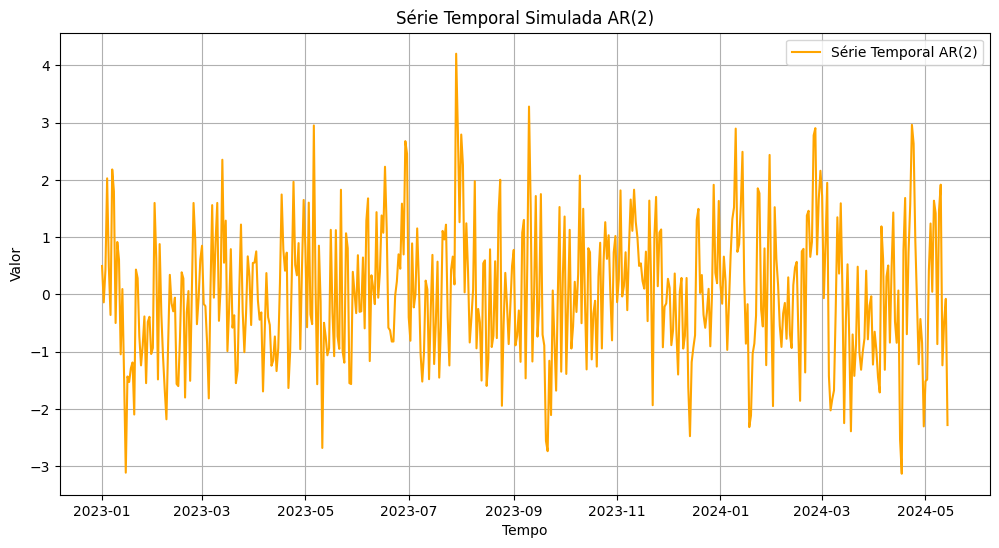

<Figure size 1200x600 with 0 Axes>

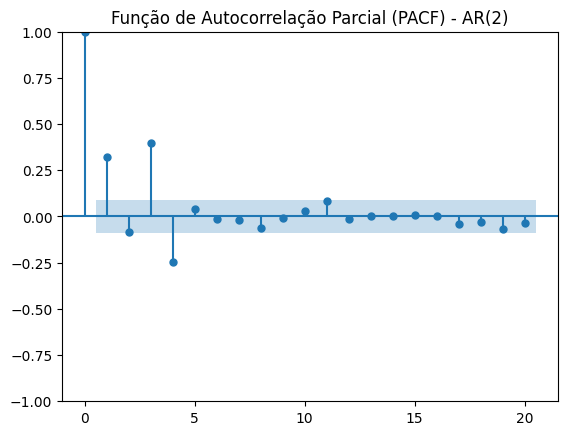

In [24]:
# Gerar uma serie temporal simulada com um processo AR (2)
np.random.seed(42)
n = 500
ar_params = [0.5, -0.3, 0.5, -0.2]
noise = np.random.normal(0, 1, n)

# Criar a série temporal AR(2)
series_ar = np.zeros(n)
series_ar[0], series_ar[1] = noise[0], noise[1]

for t in range(2, n):
    series_ar[t] = (ar_params[0] * series_ar[t-1] 
                    + ar_params[1] * series_ar[t-2] 
                    + ar_params[2] * series_ar[t-3] 
                    + ar_params[3] * series_ar[t-4] 
                    + noise[t])

# Criar DataFrame
dates = pd.date_range(start='2023-01-01', periods=n, freq='D')
ar_series = pd.Series(series_ar, index=dates, name='AR(2) Series')

# Plotar a série temporal AR(2)
plt.figure(figsize=(12, 6))
plt.plot(ar_series, label='Série Temporal AR(2)', color='orange')
plt.title('Série Temporal Simulada AR(2)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# Plotar a função de autocorrelação parcial (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(ar_series, lags=20, alpha=0.05)
plt.title('Função de Autocorrelação Parcial (PACF) - AR(2)')
plt.show()

Continuar aula 9. Modelo MA - Funcionamento